# 02_calculo_indices

Calcula ?ndices espectrales (NDVI, NDBI, NDWI, BSI) para las im?genes Sentinel-2 en `data/raw`, guarda los rasters en `data/processed` y genera estad?sticas/visualizaciones b?sicas.

In [8]:
from pathlib import Path
import numpy as np
import rasterio
import matplotlib.pyplot as plt

repo_root = Path.cwd().parent
raw_dir = repo_root / 'data' / 'raw'
processed_dir = repo_root / 'data' / 'processed'
processed_dir.mkdir(parents=True, exist_ok=True)


In [9]:
def calcular_indices(ruta_imagen: Path, ruta_salida: Path):
    """
    Calcula indices espectrales para una imagen Sentinel-2.

    Bandas Sentinel-2 (10m): B2=Blue, B3=Green, B4=Red, B8=NIR
    Bandas Sentinel-2 (20m): B11=SWIR1, B12=SWIR2
    El archivo exportado desde GEE tiene las bandas en el orden: B2,B3,B4,B8,B11,B12.
    """
    with rasterio.open(ruta_imagen) as src:
        blue = src.read(1).astype('float32') / 10000
        green = src.read(2).astype('float32') / 10000
        red = src.read(3).astype('float32') / 10000
        nir = src.read(4).astype('float32') / 10000
        swir = src.read(5).astype('float32') / 10000

        profile = src.profile

    eps = 1e-10

    ndvi = (nir - red) / (nir + red + eps)
    ndbi = (swir - nir) / (swir + nir + eps)
    ndwi = (green - nir) / (green + nir + eps)
    bsi = ((swir + red) - (nir + blue)) / ((swir + red) + (nir + blue) + eps)

    profile.update(count=4, dtype='float32')

    with rasterio.open(ruta_salida, 'w', **profile) as dst:
        dst.write(ndvi.astype('float32'), 1)
        dst.write(ndbi.astype('float32'), 2)
        dst.write(ndwi.astype('float32'), 3)
        dst.write(bsi.astype('float32'), 4)
        dst.descriptions = ('NDVI', 'NDBI', 'NDWI', 'BSI')

    return {'ndvi': ndvi, 'ndbi': ndbi, 'ndwi': ndwi, 'bsi': bsi}


In [10]:
imagenes = sorted(raw_dir.glob('sentinel2_*.tif'))
if not imagenes:
    raise FileNotFoundError('No se encontraron archivos sentinel2_*.tif en data/raw')

stats = {}
for img in imagenes:
    year = img.stem.split('_')[1]
    salida = processed_dir / f'indices_{year}.tif'
    indices = calcular_indices(img, salida)
    stats[year] = {
        'ndvi_mean': float(np.nanmean(indices['ndvi'])),
        'ndbi_mean': float(np.nanmean(indices['ndbi'])),
        'ndwi_mean': float(np.nanmean(indices['ndwi'])),
        'bsi_mean': float(np.nanmean(indices['bsi'])),
        'ndvi_std': float(np.nanstd(indices['ndvi'])),
        'ndbi_std': float(np.nanstd(indices['ndbi'])),
        'ndwi_std': float(np.nanstd(indices['ndwi'])),
        'bsi_std': float(np.nanstd(indices['bsi'])),
    }
    print(f"Procesado {year}: NDVI medio = {stats[year]['ndvi_mean']:.3f}")


Procesado 2018: NDVI medio = 0.164
Procesado 2020: NDVI medio = 0.155
Procesado 2022: NDVI medio = 0.151
Procesado 2024: NDVI medio = 0.160


In [11]:
import pandas as pd
df_stats = pd.DataFrame.from_dict(stats, orient='index').sort_index()
df_stats


,ndvi_mean,ndbi_mean,ndwi_mean,bsi_mean,ndvi_std,ndbi_std,ndwi_std,bsi_std
2018,0.164159,0.058769,-0.231218,0.097081,0.137857,0.101901,0.129635,0.073690
2020,0.155397,0.055350,-0.226239,0.098066,0.134806,0.098628,0.129094,0.069378
2022,0.151342,0.067782,-0.224396,0.102230,0.128133,0.098630,0.124109,0.068364
2024,0.160158,0.066534,-0.232320,0.101284,0.138807,0.105220,0.133136,0.074479


In [12]:
# Guardar estadisticas
salida_csv = processed_dir / 'estadisticas_indices.csv'
df_stats.to_csv(salida_csv, index=True)
print('Estadisticas guardadas en', salida_csv)


Estadisticas guardadas en D:\GitHub\laboratorio_cambio_urbano\data\processed\estadisticas_indices.csv


## Visualizacion comparativa (lado a lado)
Se muestra NDVI para cada fecha como ejemplo.


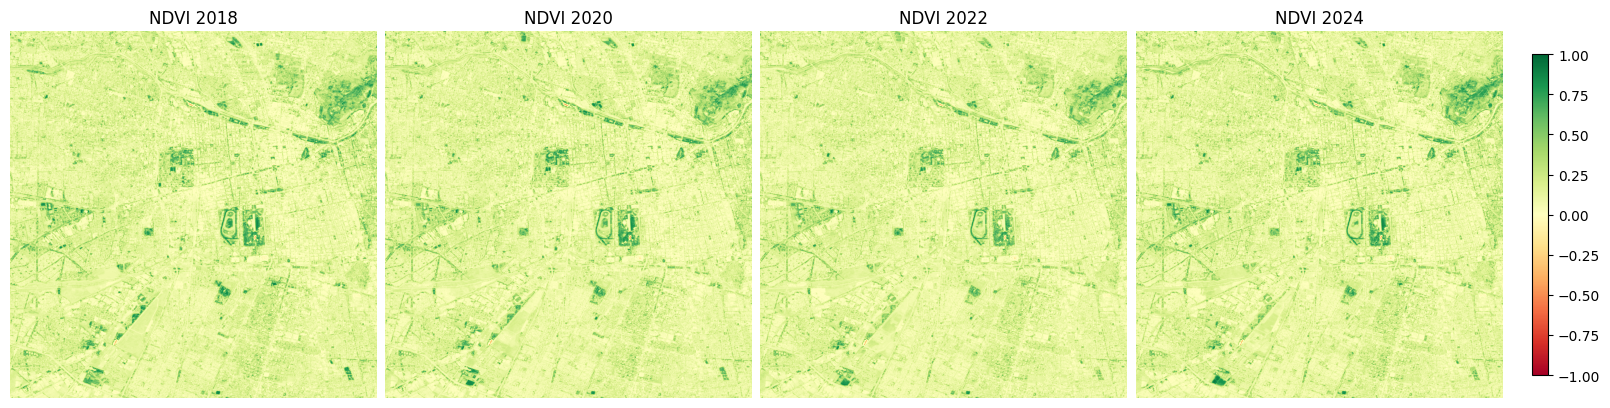

In [13]:
fig, axes = plt.subplots(1, len(imagenes), figsize=(4 * len(imagenes), 4), constrained_layout=True)
if len(imagenes) == 1:
    axes = [axes]

for ax, img in zip(axes, imagenes):
    year = img.stem.split('_')[1]
    indice_path = processed_dir / f'indices_{year}.tif'
    with rasterio.open(indice_path) as src:
        ndvi = src.read(1)
    im = ax.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
    ax.set_title(f'NDVI {year}')
    ax.axis('off')

fig.colorbar(im, ax=axes, location='right', shrink=0.85, pad=0.02)
plt.show()


## Histogramas por indice
Histogramas simples para NDVI/NDBI/NDWI/BSI (todas las fechas combinadas).


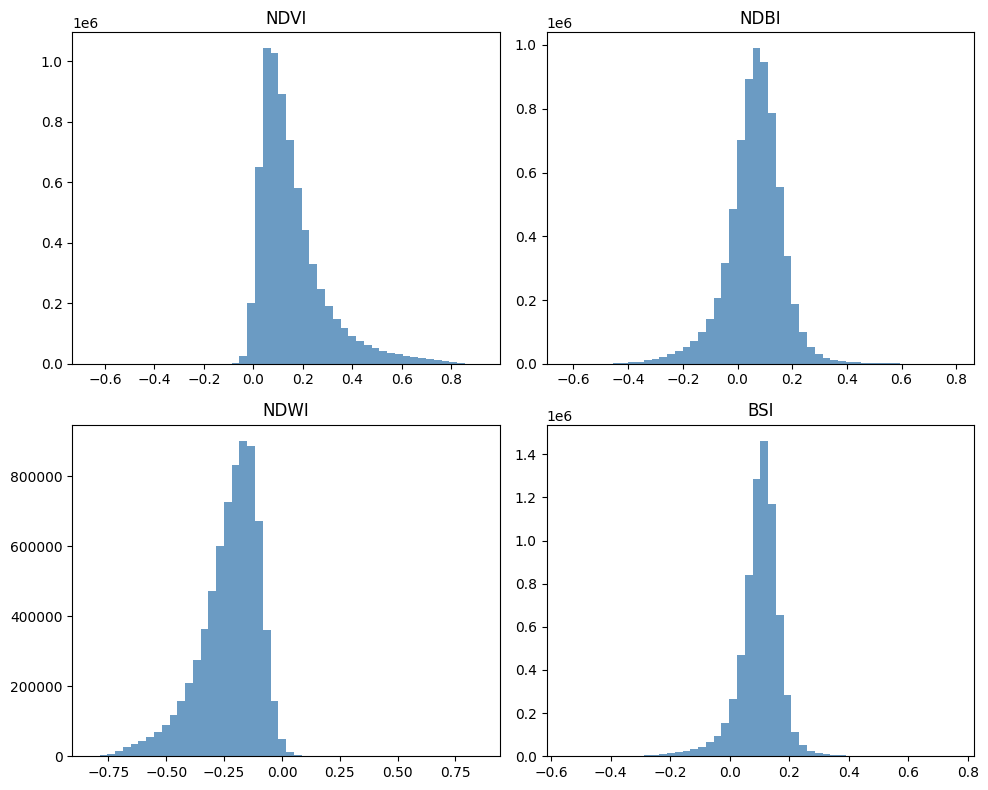

In [14]:
all_indices = {'ndvi': [], 'ndbi': [], 'ndwi': [], 'bsi': []}
for img in imagenes:
    year = img.stem.split('_')[1]
    indice_path = processed_dir / f'indices_{year}.tif'
    with rasterio.open(indice_path) as src:
        all_indices['ndvi'].append(src.read(1).ravel())
        all_indices['ndbi'].append(src.read(2).ravel())
        all_indices['ndwi'].append(src.read(3).ravel())
        all_indices['bsi'].append(src.read(4).ravel())

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()
for ax, key in zip(axes, ['ndvi', 'ndbi', 'ndwi', 'bsi']):
    data = np.concatenate(all_indices[key])
    data = data[np.isfinite(data)]
    ax.hist(data, bins=50, color='steelblue', alpha=0.8)
    ax.set_title(key.upper())

plt.tight_layout()
plt.show()
